In [1]:
import matplotlib.pyplot as plt
import numpy as np
import PIL
from PIL import Image
import tensorflow as tf
import os
import cv2
from tensorflow import keras
from tensorflow.keras import layers, models
from tensorflow.keras.models import Sequential

In [2]:
gpu = tf.config.experimental.list_physical_devices('CPU')
print(gpu)

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU')]


In [3]:
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
  tf.config.experimental.set_memory_growth(gpu,True)

In [4]:
healthy_dataset_dir = r'/content/drive/MyDrive/Colab Notebooks/BananaLSD/AugmentedSet/healthy'
cordona_dataset_dir = r'/content/drive/MyDrive/Colab Notebooks/BananaLSD/AugmentedSet/cordana'
pesta_dataset_dir = r'/content/drive/MyDrive/Colab Notebooks/BananaLSD/AugmentedSet/pestalotiopsis'
siga_dataset_dir = r'/content/drive/MyDrive/Colab Notebooks/BananaLSD/AugmentedSet/sigatoka'
images_h = []#400
images_c = []#328
images_p =[]#217
images_s= []#209

for filename in os.listdir(healthy_dataset_dir):
  img = (os.path.join(healthy_dataset_dir,filename))
  images_h.append(img)
for filename in os.listdir(cordona_dataset_dir):
  img = (os.path.join(cordona_dataset_dir,filename))
  images_c.append(img)
for filename in os.listdir(pesta_dataset_dir):
  img = (os.path.join(pesta_dataset_dir,filename))
  images_p.append(img)
for filename in os.listdir(siga_dataset_dir):
  img = (os.path.join(siga_dataset_dir,filename))
  images_s.append(img)

In [5]:
print(len(images_h))
print(len(images_c))
print(len(images_p))
print(len(images_s))

400
328
217
209


In [6]:
train = images_h[:100] + images_c[:100] + images_p[:100] + images_s[:100]
test = images_h[100:120] + images_c[100:120] + images_p[100:120] + images_s[100:120]

In [7]:
len(train)

400

In [8]:
images_s[35]

'/content/drive/MyDrive/Colab Notebooks/BananaLSD/AugmentedSet/sigatoka/33_aug.jpeg'

In [9]:
img  = cv2.imread(images_s[35]) #224x224x3

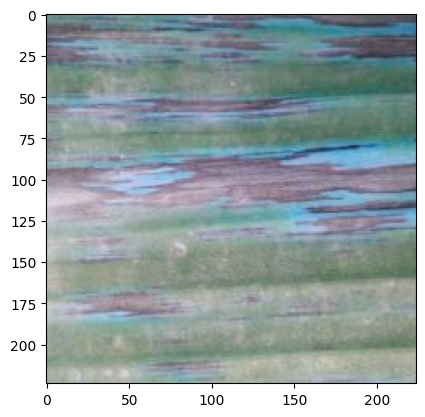

In [10]:
plt.imshow(img)

In [11]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from glob import glob
import sklearn.metrics as metrics
import tensorflow as tf
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Flatten, Dense
from tensorflow.keras.applications import VGG16

In [12]:
shape = [224,224]
classes = 4
batch_size = 32
epochs = 5

In [14]:
class_values = []
class_values2 = []

df_train = pd.DataFrame({"image_path": train})
df_test = pd.DataFrame({"image_path": test})

for i in range(len(df_train)):
  if i<100:
    class_values.append('healthy')
  elif 100<=i<200:
    class_values.append('cordana')
  elif 200<=i<300:
    class_values.append('pestalotiopsis')
  else:
    class_values.append('sigatoka')

for j in range(len(df_test)):
  if j<20:
    class_values2.append('healthy')
  elif 20<=j<40:
    class_values2.append('cordana')
  elif 40<=j<60:
    class_values2.append('pestalotiopsis')
  else:
    class_values2.append('sigatoka')

df_train["class"] = class_values
df_test["class"] = class_values2


In [15]:
#shuffle dataframe
df_train_shuffled = df_train.sample(frac=1, random_state=42).reset_index(drop=True)
df_test_shuffled = df_test.sample(frac=1, random_state=42).reset_index(drop=True)

In [16]:
df_train_shuffled#/content/drive/MyDrive/Colab Notebooks/BananaL...

,image_path,class
0,/content/drive/MyDrive/Colab Notebooks/BananaL...,pestalotiopsis
1,/content/drive/MyDrive/Colab Notebooks/BananaL...,pestalotiopsis
2,/content/drive/MyDrive/Colab Notebooks/BananaL...,healthy
3,/content/drive/MyDrive/Colab Notebooks/BananaL...,pestalotiopsis
4,/content/drive/MyDrive/Colab Notebooks/BananaL...,healthy
...,...,...
395,/content/drive/MyDrive/Colab Notebooks/BananaL...,healthy
396,/content/drive/MyDrive/Colab Notebooks/BananaL...,cordana
397,/content/drive/MyDrive/Colab Notebooks/BananaL...,pestalotiopsis
398,/content/drive/MyDrive/Colab Notebooks/BananaL...,sigatoka


In [18]:
trdata = ImageDataGenerator()
train_data_gen = trdata.flow_from_dataframe(dataframe = df_train_shuffled,
                                            x_col ='image_path',
                                            y_col = 'class',
                                            target_size=(224,224),
                                            shuffle=False,
                                            class_mode='categorical')
tsdata = ImageDataGenerator()
test_data_gen = tsdata.flow_from_dataframe(x_col = 'image_path',
                                           y_col = 'class',
                                           dataframe = df_test_shuffled,
                                           target_size=(224,224),
                                           shuffle=False,
                                           class_mode='categorical')

Found 400 validated image filenames belonging to 4 classes.
Found 80 validated image filenames belonging to 4 classes.


In [ ]:
#CNN with 16 layers - VGG
vgg = VGG16(input_shape = (224,224,3), weights = 'imagenet', include_top = False)
for layer in vgg.layers:
  layer.trainable = False
x = Flatten()(vgg.output)
x = Dense(128, activation = 'relu')(x)
x = Dense(64, activation = 'relu')(x)
x = Dense(classes, activation = 'softmax')(x)
model = Model(inputs = vgg.input, outputs = x)
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [27]:
#Lenet

#CNN layers
model = models.Sequential()
model.add(layers.Conv2D(32,(3,3), activation='relu', input_shape=(224,224,3)))
model.add(layers.AveragePooling2D((2,2)))
model.add(layers.Activation('sigmoid'))
model.add(layers.Conv2D(64,(3,3), activation='relu'))
model.add(layers.AveragePooling2D((2,2)))
model.add(layers.Activation('sigmoid'))
model.add(layers.Conv2D(128, (3,3), activation='relu'))
model.add(layers.Flatten())

#fully connected layers
model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(64, activation='relu'))

#output layers
model.add(layers.Dense(4, activation='softmax'))

#model.summary()
#Lenet compilation
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [34]:
#resnet
res = tf.keras.applications.ResNet101V2(
    include_top=False,
    weights='imagenet',
    input_tensor=None,
    input_shape=(224,224,3),
    pooling=None,
    classes=4,
    classifier_activation='softmax'
)
x = Flatten()(res.output)
#x = Dense(128, activation = 'relu')(x)
#x = Dense(64, activation = 'relu')(x)
x = Dense(classes, activation = 'softmax')(x)
model = Model(inputs = res.input, outputs = x)
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [ ]:
#training model
training_steps_per_epoch = np.ceil(train_data_gen.samples / batch_size)
validation_steps_per_epoch = np.ceil(test_data_gen.samples / batch_size)
model.fit_generator(train_data_gen, steps_per_epoch = training_steps_per_epoch, validation_data=test_data_gen, validation_steps=validation_steps_per_epoch,epochs=epochs, verbose=1)
print('Training Completed!')

<ipython-input-35-e35829f56d75>:4: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  model.fit_generator(train_data_gen, steps_per_epoch = training_steps_per_epoch, validation_data=test_data_gen, validation_steps=validation_steps_per_epoch,epochs=epochs, verbose=1)


Epoch 1/5
13/13 [==============================] - 530s 36s/step - loss: 2.4961 - accuracy: 0.5900 - val_loss: 5552.9517 - val_accuracy: 0.2750
Epoch 2/5
13/13 [==============================] - 460s 35s/step - loss: 1.4673 - accuracy: 0.5575 - val_loss: 12492785664.0000 - val_accuracy: 0.2500
Epoch 3/5
13/13 [==============================] - 460s 35s/step - loss: 2.1884 - accuracy: 0.5650 - val_loss: 36776300544.0000 - val_accuracy: 0.2500
Epoch 4/5
13/13 [==============================] - 458s 37s/step - loss: 1.6567 - accuracy: 0.5750 - val_loss: 717893248.0000 - val_accuracy: 0.2500
Epoch 5/5
13/13 [==============================] - 457s 35s/step - loss: 2.2364 - accuracy: 0.5300 - val_loss: 53483405312.0000 - val_accuracy: 0.2250
Training Completed!


In [ ]:
Y_pred = model.predict(test_data_gen, test_data_gen.samples / batch_size)
val_preds = np.argmax(Y_pred, axis=1)
import sklearn.metrics as metrics
val_trues =test_data_gen.classes
from sklearn.metrics import classification_report
print(classification_report(val_trues, val_preds))

3/3 [==============================] - 24s 6s/step
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        20
           1       0.14      0.10      0.12        20
           2       0.24      0.80      0.37        20
           3       0.00      0.00      0.00        20

    accuracy                           0.23        80
   macro avg       0.10      0.23      0.12        80
weighted avg       0.10      0.23      0.12        80



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
keras_file="Model.h5"
tf.keras.models.save_model(model,keras_file)

<ipython-input-97-981ad33596cb>:2: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  tf.keras.models.save_model(model,keras_file)


In [ ]:
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.vgg16 import preprocess_input, decode_predictions
import numpy as np
#load saved model
model = load_model('Model.h5')
img_path = ['1_aug.jpeg','0_aug.jpeg','2_aug.jpeg','6_aug.jpeg',
            '14_aug.jpeg','50_aug.jpeg','34_aug.jpeg','74_aug.jpeg',
            '13_aug.jpeg','77_aug.jpeg']
for i in img_path:
  img = image.load_img(i, target_size=(224, 224))
  x = image.img_to_array(img)
  x = np.expand_dims(x, axis=0)
  x = preprocess_input(x)
  preds=model.predict(x)
  # create a list containing the class labels
  class_labels = ['cordona','healthy','pestalotiopsis','sigatoka']
  # find the index of the class with maximum score
  pred = np.argmax(preds, axis=-1)
  # print the label of the class with maximum score
  print(class_labels[pred[0]])

1/1 [==============================] - 1s 1s/step
healthy
1/1 [==============================] - 1s 625ms/step
pestalotiopsis
1/1 [==============================] - 1s 595ms/step
cordona
1/1 [==============================] - 1s 571ms/step
sigatoka
1/1 [==============================] - 1s 563ms/step
pestalotiopsis
1/1 [==============================] - 1s 562ms/step
pestalotiopsis
1/1 [==============================] - 1s 564ms/step
cordona
1/1 [==============================] - 1s 551ms/step
sigatoka
1/1 [==============================] - 1s 559ms/step
healthy
1/1 [==============================] - 1s 546ms/step
healthy


In [ ]:
#pes = 0,14
#h = 1,50,13,77
#c = 2,34
# s = 6,74